In [1]:
import winning_chances_util
import winning_chances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lichess_code 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [2]:
df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")
df=lichess_code.add_total_accuracy(df)
summary_table=lichess_code.create_summary_table(df)

In [ ]:
# Assuming 'df' contains the columns 'GameID', 'Player', and 'Total_Accuracy'

# Remove duplicates to ensure one entry per player per game
df_unique = df[['GameID', 'Player', 'Total_Accuracy']].drop_duplicates()

# Sort the DataFrame by 'Total_Accuracy' in ascending order
df_sorted = df_unique.sort_values('Total_Accuracy', ascending=True)

# Get the top 5 entries with the lowest Total_Accuracy scores
lowest_5 = df_sorted.head(10) 

# Display the GameIDs, Players, and their Total_Accuracy scores
print("Games with the lowest 5 Total_Accuracy scores:")
print(lowest_5[['GameID', 'Player', 'Total_Accuracy']])


Games with the lowest 5 Total_Accuracy scores:
          GameID Player  Total_Accuracy
2855507  34648.0  White       15.961005
1265754  15051.0  White       17.481708
1265755  15051.0  Black       18.480995
2882984  35021.0  White       20.136249
2859451  34707.0  Black       20.544295
2882985  35021.0  Black       20.654277
2287092  27708.0  White       21.030625
1242897  14755.0  White       23.551820
2855508  34648.0  Black       23.683236
1242898  14755.0  Black       23.962847


In [11]:
low_elo = summary_table[ (summary_table['Elo'] <= 1500)]
low_elo.head()

,GameID,Year,Opening,Variation,Result,TotalMoves,Player,Name,Elo,FideId,Total_Accuracy
632,317.0,2021.0,Ruy Lopez,fianchetto defence deferred,0-1,64.0,White,"Polukhin,Sergey",1410.0,24252018.0,90.158296
635,318.0,2021.0,Other,Unknown,1-0,39.0,Black,"Iljin,Viktor",1066.0,34413472.0,76.550521
654,334.0,2021.0,Sicilian,Grand Prix attack,1/2-1/2,66.0,White,"Polukhin,Sergey",1410.0,24252018.0,89.908060
659,336.0,2021.0,King's pawn opening,Unknown,1-0,116.0,Black,"Iljin,Viktor",1066.0,34413472.0,88.716945
668,343.0,2021.0,French,exchange variation,1/2-1/2,94.0,White,"Polukhin,Sergey",1410.0,24252018.0,89.976157


In [12]:
lichess_code.export_game_to_pgn(df,317,'../game1.pgn')

In [4]:
top_100_openings = summary_table['Opening'].value_counts().nlargest(50).index.tolist()
summary_table['Opening'] = summary_table['Opening'].apply(lambda x: x if x in top_100_openings else 'Other')

new_summary_table = summary_table[summary_table['Player'] == 'White'].copy()
#new_summary_table = new_summary_table[ (new_summary_table['TotalMoves'] <= 60)]

In [ ]:
def linear_regression_model(summary_table, categorical_features, numerical_features, test_size=0.2, random_state=42):
   
    # Prepare the feature matrix X and target vector y
    features = categorical_features + numerical_features
    X = summary_table[features]
    y = summary_table['Elo']

    # Handle missing values
    X = X.fillna(0)
    y = y.fillna(0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Create a ColumnTransformer to encode categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'  # Keep numerical features as is
    )

    # Create a pipeline that first transforms the data then applies Linear Regression
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R-squared Score (R²): {r2:.2f}')

    # Optional: Get the coefficients of the model
    # Get feature names after one-hot encoding
    onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    # Combine with numerical feature names
    feature_names = np.concatenate([onehot_feature_names, numerical_features])

    # Get coefficients from the model
    coefficients = pipeline.named_steps['regressor'].coef_

    # Create a DataFrame to display feature names and their coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Display the coefficients
    print("\nCoefficients of the model:")
    print(coef_df)




In [8]:
# Example usage:
# Define your categorical and numerical features
categorical_features = ['Opening', 'Variation', 'Result']
numerical_features = ['Total_Accuracy', 'TotalMoves']

# Call the function with your summary_table DataFrame
linear_regression_model(new_summary_table, categorical_features, numerical_features)

Root Mean Squared Error (RMSE): 493.22
R-squared Score (R²): 0.11

Coefficients of the model:
                         Feature  Coefficient
0     Opening_Alekhine's defence  -116.357868
1        Opening_Benko's opening    62.318482
2                 Opening_Benoni   114.657720
3         Opening_Benoni defence    71.956657
4         Opening_Bird's opening  -225.072178
...                          ...          ...
1003                  Result_1-0    19.377237
1004               Result_1-0 ff    93.215214
1005              Result_1/2-1/2    13.400114
1006              Total_Accuracy    12.073074
1007                  TotalMoves     0.635722

[1008 rows x 2 columns]


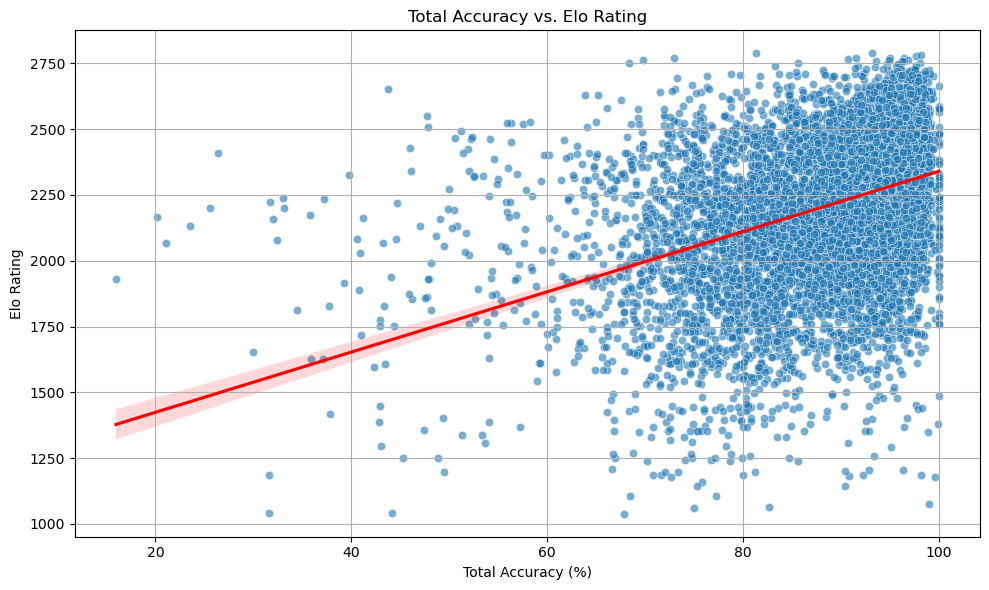

In [75]:
plot_data = new_summary_table.dropna(subset=['Total_Accuracy', 'Elo'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='Total_Accuracy', y='Elo', alpha=0.6)

# Add a regression line
sns.regplot(data=plot_data, x='Total_Accuracy', y='Elo', scatter=False, color='red')

# Customize the plot
plt.title('Total Accuracy vs. Elo Rating')
plt.xlabel('Total Accuracy (%)')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\foivo\AppData\Local\Temp\ipykernel_38848\771771032.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()


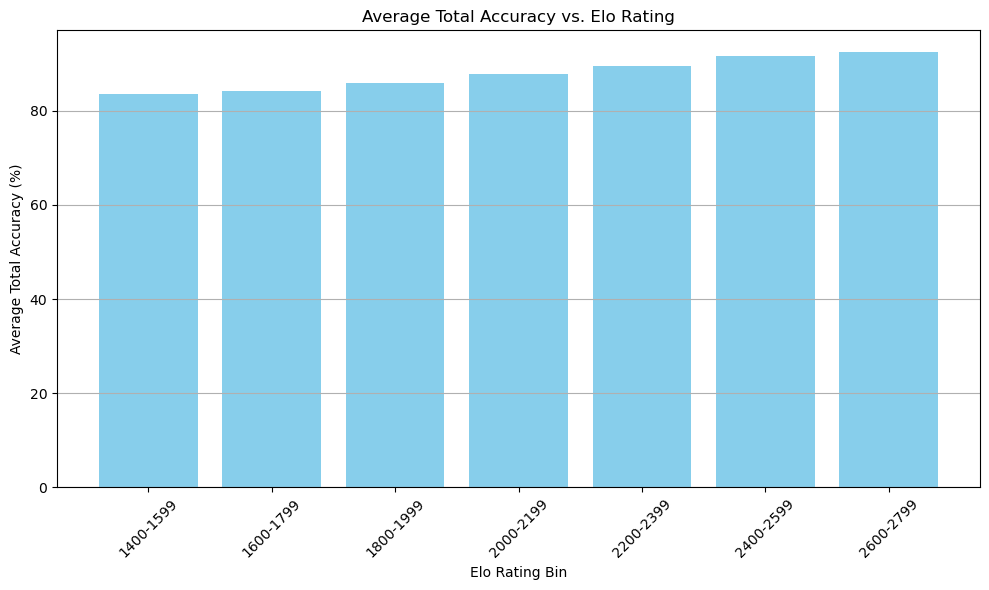

In [9]:

# Remove any rows with missing 'Elo' or 'Total_Accuracy'
data = new_summary_table.dropna(subset=['Elo', 'Total_Accuracy']).copy()

# Ensure 'Elo' is numeric
data['Elo'] = pd.to_numeric(data['Elo'], errors='coerce')

# Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]

elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1]
    upper = upper - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
data['EloBin'] = pd.cut(
    data['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Remove any rows where 'EloBin' is NaN (in case 'Elo' is outside the bins)
data = data.dropna(subset=['EloBin'])

# Compute average Total Accuracy per Elo bin
avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()

# Sort the bins in order
avg_accuracy_per_elo_bin['EloBin'] = pd.Categorical(avg_accuracy_per_elo_bin['EloBin'], categories=elo_labels, ordered=True)
avg_accuracy_per_elo_bin = avg_accuracy_per_elo_bin.sort_values('EloBin')

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(avg_accuracy_per_elo_bin['EloBin'], avg_accuracy_per_elo_bin['Total_Accuracy'], color='skyblue')
plt.title('Average Total Accuracy vs. Elo Rating')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Total Accuracy (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
def cp_to_win_percent(cp):
    """
    Convert centipawn evaluation to win percentage using the Lichess formula.

    Parameters:
    cp (float or np.array): Centipawn evaluation(s)

    Returns:
    float or np.array: Win percentage(s)
    """
    # Ensure cp is a NumPy array for vectorized operations
    cp = np.array(cp)
    
    # Apply the Lichess formula
    win_percent = 50 + 50 * (2 / (1 + np.exp(-0.00368208 * cp)) - 1)
    return win_percent

def compute_volatility_weights(df):
    """
    Compute weights based on game volatility for each move in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing chess game data with centipawn evaluations.

    Returns:
    pd.DataFrame: DataFrame with an additional 'Weight' column for each move.
    """
    # Ensure the DataFrame is sorted by GameID and MoveNumber
    df = df.sort_values(by=['GameID', 'MoveNumber']).reset_index(drop=True)
    
    # Define minimum and maximum weights
    min_weight = 0.5
    max_weight = 12.0
    
    # List to collect DataFrames for each game
    result = []
    
    # Group the DataFrame by GameID
    for game_id, game_df in df.groupby('GameID'):
        # Reset index for the game DataFrame
        game_df = game_df.reset_index(drop=True)
        
        # Extract centipawn evaluations (assuming the column is named 'CP')
        cps = game_df['CP'].values
        # Convert CP evaluations to WinPercent
        win_percents = cp_to_win_percent(cps)
        # Prepend the initial evaluation
        win_percents = np.insert(win_percents, 0, win_percents[0])
        
        # Determine window size
        total_moves = len(win_percents)
        window_size = max(2, min(8, total_moves // 10))
        
        # Compute weights for each move
        weights = []
        for i in range(1, total_moves):
            # Define the window around the current move
            start_idx = max(0, i - window_size // 2)
            end_idx = min(total_moves, i + window_size // 2)
            window = win_percents[start_idx:end_idx]
            # Compute volatility (standard deviation)
            volatility = np.std(window)
            # Clamp the weight between min_weight and max_weight
            weight = max(min_weight, min(max_weight, volatility))
            weights.append(weight)
        
        # Assign weights to the game DataFrame (excluding the initial prepended move)
        game_df['Volatility_Weight'] = weights
        result.append(game_df)
    
    # Concatenate all game DataFrames
    df_with_weights = pd.concat(result, ignore_index=True)
    return df_with_weights

def compute_move_accuracy(df):
    """
    Compute the accuracy percentage for a move based on win percentages before and after the move.
    """
    if 'CP' not in df.columns:
        df['CP'] = df['Evaluation'] * 100
        df['WinPercent'] = cp_to_win_percent(df['CP'])
        df['WinPercentBefore'] = df.groupby('GameID')['WinPercent'].shift(1)
        df['WinPercentBefore'] = df['WinPercentBefore'].fillna(df['WinPercent'])
        df = compute_volatility_weights(df)
    
    delta_win_percent = df['WinPercentBefore'] - df['WinPercent']
    accuracy_percent = 103.1668 * np.exp(-0.04354 * delta_win_percent) - 3.1669
    # Clamp the accuracy between 0 and 100
    accuracy_percent = np.clip(accuracy_percent, 0, 100)
    df['Move_Accuracy']=accuracy_percent
    return df

def add_total_accuracy(df):
    # Ensure 'Player' column exists
    if 'Player' not in df.columns:
        df['Player'] = np.where(df['MoveNumber'] % 2 != 0, 'White', 'Black')
    df=compute_move_accuracy(df)
    # Function to compute Total Accuracy for a player's moves in a game
    def compute_total_accuracy(group):
        A_i = group['Move_Accuracy'].values  # Move accuracies
        w_i = group['Volatility_Weight'].values  # Volatility weights
        n = len(A_i)  # Number of moves

        # Handle zero accuracies to prevent division by zero
        A_i_nonzero = np.where(A_i == 0, 0.1, A_i)

        # Weighted Mean Accuracy
        weighted_mean = np.sum(w_i * A_i) / np.sum(w_i)

        # Harmonic Mean Accuracy
        harmonic_mean = n / np.sum(1 / A_i_nonzero)

        # Total Accuracy
        total_accuracy = (weighted_mean + harmonic_mean) / 2

        return total_accuracy

    # Compute Total Accuracy per game per player
    total_accuracy_df = df.groupby(['GameID', 'Player'], sort=False).apply(compute_total_accuracy).reset_index(name='Total_Accuracy')

    # Merge the total accuracies back into the original DataFrame without changing the row order
    df = df.merge(total_accuracy_df, on=['GameID', 'Player'], how='left', sort=False)

    return df